# Testing out numerical solver code

## current setup
crank-nicholson gmres solver and pme cell diffusion 

## Objectives 
* i think to do this you'll need to do a sweep over induction start and end times for each sender type. do this by starting and stopping simulations, toggling xSa/b to 0 and back, then continuing. 
* scale the size of the colony too? put in a no-amplify control as well?

## Model considerations 



$$ \partial_t c = F(c)$$
$$ \partial_t c = (D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)$$
Crank-Nicolson approach is to take 
$$ \frac{c_{n+1}-c_n}{\Delta t} = \frac{F(c_n)+F(c_{n+1})}{2} $$
When jacobian is available
$$ c_{n+1} = c_n + \Delta t \frac{F(c_n)+F(c_n) + J(c)(c_{n+1}-c_n))}{2} $$
$$ (1 - \Delta t J(c)/2) c_{n+1}  = (1 - \Delta t J(c_n)/2)c_n  + \Delta t F(c)$$
$$ (D_a+2D_c)\nabla^2c_n + 2D_c|\nabla c_n|^2+f(c_n) + (D_a+2D_c)\nabla^2c_{n+1} + 2D_c|\nabla c_{n+1}|^2+f(c_{n+1})$$
$$ c_{n-1} = c_n \Delta t ((D_a+2D_c)\nabla^2c + 2D_c|\nabla c|^2+f(c)) $$



In [2]:
# imports
from __future__ import division, print_function

import itertools as itt
import time

import numpy as np
import pandas as pd
import os
import sys
import string
import selenium
import scipy.integrate as itg
import scipy.optimize as opt
import scipy.interpolate as itp
import scipy.ndimage as ndi
import scipy.sparse as sparse

import matplotlib as mpl
mpl.use("Agg")

import itertools

import matplotlib.pyplot as plt 
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!

import matplotlib.animation as anm
import skimage.measure
import skimage.filters
import numba
import gc

from multiprocessing import Pool, Process

# %load_ext memory_profiler
# %load_ext line_profiler
import timeit

from IPython.display import HTML

%matplotlib inline

In [2]:
import multiprocessing

In [3]:
os.environ['OMP_NUM_THREADS'] = '8'

## 2D Discrete Laplacian

In continuous form : 
$$ U_t = \triangle U - \lambda U $$

In discrete form, for point $i$ : 
$$ \Delta U_i = \sum_{1 = w(i,j)}\omega(i,j)(U_i - U_j) - \lambda U_i $$

Use discrete laplacian approximation w/o diagonals for grid spacing, so that we can have zero-flux  boundary conditions. 

$$ L = 
 \begin{pmatrix}
  0 & 1 & 0 \\
  1 & -4 & 1 \\
  0 & 1 & 0 
 \end{pmatrix} $$

I use a convolution function to calculate the diffusion terms. 

# Try to find out why solvers quit with too_small_step error

In [4]:
import importlib
from omnisim import chain_omnisim as oms
oms = importlib.reload(oms)

In [5]:
# Params :    ,Dc,    rc,    rS,   rR,    Hn,Kn,   Dn,     kn,       Da,     xa,  xs,   xS,
p0 = np.array([1e-7,  2.6e-4, 2e-4, 8e-6,  4, 68,  1.14e-6, 1.6e-2, 2e-4, (1e-7), 250, 300,
#xr, hS,   kS,  hR, kR,  hC,  kC,    pa,  leak   min_od
13, 2.5,  133, 2.3, 40, 2.2, 1.13e4, 3e-5, 0, 0.02], dtype=np.float64)
# Define parameter values to sample
Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od = p0
od0 = 1

cs_i, cra_i, crb_i, crc_i, crd_i, cp_i, n_i, aa_i, ab_i, ac_i, ad_i, sa_i, sb_i, sc_i, sd_i, ra_i, rb_i, rc_i, rd_i  = np.arange(oms.species)
simmer = oms.Simulator(scale=16)
# simmer.set_scale(4)
# simmer.t_eval = np.arange(0,24*60,2).astype(np.float)

In [5]:
1/(Da*6*simmer.scale**2)

3.255208333333333

In [18]:
def new_init_conditions(simmer, n_spots=100, weights=[1,1,1,1,1,100]):
    w_vec = np.array(weights)
    w_vec = w_vec/np.sum(w_vec)
    simmer.basedims = np.array([4,4])
    simmer.set_scale(simmer.scale)
    scale = simmer.scale
    simmer.t_eval = np.linspace(0,11*60*60,200)
    ns, nh, nw = simmer.initial_array.shape
    simmer.initial_array = np.zeros_like(simmer.initial_array)
    simmer.initial_array[n_i,:,:] = 100
    odval = 3e-3*simmer.scale**2
    r_vec = np.linspace(1e-3,0.7)*scale
    appx_distr = (r_vec)/np.sum(r_vec)
#     weights = np.array(weights)
#     n_ci_spots = n_spots*weights / np.sum(weights)
    ci_vec = oms.cell_inds
    for ci, ci_spots in zip(ci_vec, weights):
        for i in range(np.int(ci_spots)):
            r = np.random.choice(r_vec,1,p=appx_distr)
            theta = np.random.uniform(0,2*np.pi,size=(1,))
            x, y = np.int(r*np.cos(theta)+nw/2), np.int(r*np.sin(theta)+nh/2)
            simmer.initial_array[ci,y,x] = odval


In [6]:
new_init_conditions(simmer)

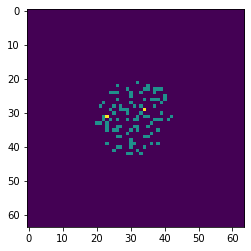

In [7]:
# species = 12
# cr_i, csa_i, csb_i, cpa_i, cpb_i, n_i, aa_i, ab_i, sa_i, sb_i, ra_i, rb_i = np.arange(species)
plt.imshow(simmer.initial_array[oms.cell_inds,:,:].sum(axis=0),interpolation='none')

In [20]:
# simmer.set_p0(p0)

from omnisim.solvers import cn_gmres_2d_lineardiff as cn_gmres
cn_gmres = importlib.reload(cn_gmres)
# impexp = cn_gmres_2d.CNMGRK(simmer, 0, 2*60, first_step=5, rk_step=5e-2)

In [36]:
 ns, nh, nw, _ = simmer.dims
# simmer = oms.Simulator(scale=8)
ys = []
ts = []
for dt in [3]:#[5,2,1,0.5,0.1]:
#     new_init_conditions(simmer)
    simmer.set_p0(p0)
#     simmer.initial_array = initial_array.copy()
    impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
    n_loops = np.int(12*3600/dt)
    rtime = time.time()
    for i in np.arange(n_loops):
        status, msg = impexp._step_impl()
        if status==False:
            print(msg)
            break
        if i%20:
            continue
        else:
            ys.append(impexp.y.copy())
            ts.append(i*dt)
        if i%1000:
            continue
        else:
            print("iteration:{} dt:{}".format(i,dt))
            print(dt*i/(time.time() - rtime))

    rtime = time.time() - rtime

species, nh, nw, dx = simmer.dims
ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
ys_stack = np.concatenate(ys_reshaped,axis=0)

iteration:0 dt:3
0.0
iteration:100 dt:3
185.36235551932316
iteration:200 dt:3
180.82336352490043
iteration:300 dt:3
171.59598978335544
iteration:400 dt:3
165.66270499018776
iteration:500 dt:3
168.1459731597435
iteration:600 dt:3
169.7186671652441
iteration:700 dt:3
170.47715511565107
iteration:800 dt:3
170.96857421616423
iteration:900 dt:3
170.8645398506867
iteration:1000 dt:3
170.38166884615814
iteration:1100 dt:3
170.48098296603314
iteration:1200 dt:3
170.5009442568131
iteration:1300 dt:3
170.04829921507928
iteration:1400 dt:3
170.19164659062577
iteration:1500 dt:3
168.98612931521984
iteration:1600 dt:3
168.11820470567088
iteration:1700 dt:3
167.39039436864573
iteration:1800 dt:3
166.30260424794687
iteration:1900 dt:3
165.74992139585515
iteration:2000 dt:3
165.1647709283608
iteration:2100 dt:3
164.12821251981615
iteration:2200 dt:3
163.70513316929078
iteration:2300 dt:3
163.0421585873863
iteration:2400 dt:3
162.49701314301018
iteration:2500 dt:3
162.02625781671745
iteration:2600 dt:3

In [ ]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()

stack_tmpl = 'worker_outputs/chain_tiffstack_{}_id{:0d}.tif'
sim_tmpl = './worker_outputs/chain_{}_it{:0d}.tif'
tvc_tmpl = './worker_outputs/chain_{}_it{:0d}_tvc.npy'
dt = 3
for loop_i in np.arange(10):
    ns, nh, nw, _ = simmer.dims
    xs_vars = (('sa',250),('sr',0))
    new_init_conditions(simmer)
    for csnr, xs in xs_vars:        
        ys = []
        ts = []
        p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
        simmer.set_p0(p0)
        impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
        n_loops = np.int(14*3600/dt)
        rtime = time.time()
        for i in np.arange(n_loops):
            status, msg = impexp._step_impl()
            if status==False:
                print(msg)
                break
            if i%20:
                continue
            else:
                ys.append(impexp.y.copy())
                ts.append(i*dt)
            if i%1000:
                continue
            else:
                print("completion:{:0.2f} dt:{}, loop:{}, cnsr:{}".format(i/n_loops,dt,loop_i,csnr))
                print(dt*i/(time.time() - rtime))
        rtime = time.time() - rtime
        print("runtime:{:0.3f} minutes".format(rtime/60))
        species, nh, nw, dx = simmer.dims
        ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
        ys_stack = np.concatenate(ys_reshaped,axis=0)
        out_fn = sim_tmpl.format(csnr, loop_i)
        skimage.io.imsave(out_fn,ys_stack,plugin='tifffile')
        out_fn = tvc_tmpl.format(csnr, loop_i)
        np.save(out_fn, np.array(ts))
        print(out_fn)
    

completion:0.00 dt:3, loop:0, cnsr:sa
0.0
completion:0.06 dt:3, loop:0, cnsr:sa
99.94746426513595
completion:0.12 dt:3, loop:0, cnsr:sa
104.66778584260598
completion:0.18 dt:3, loop:0, cnsr:sa
100.52774492489125
completion:0.24 dt:3, loop:0, cnsr:sa
98.70611250838759
completion:0.30 dt:3, loop:0, cnsr:sa
99.09970263596452
completion:0.36 dt:3, loop:0, cnsr:sa
98.85499702993637
completion:0.42 dt:3, loop:0, cnsr:sa
98.44559894156957
completion:0.48 dt:3, loop:0, cnsr:sa
97.9099512659205
completion:0.54 dt:3, loop:0, cnsr:sa
97.99178778650965
completion:0.60 dt:3, loop:0, cnsr:sa
97.57588939938228
completion:0.65 dt:3, loop:0, cnsr:sa
97.35208166557948
completion:0.71 dt:3, loop:0, cnsr:sa
97.32369102822658
completion:0.77 dt:3, loop:0, cnsr:sa
97.30335122362587
completion:0.83 dt:3, loop:0, cnsr:sa
97.29533400581738
completion:0.89 dt:3, loop:0, cnsr:sa
96.67863421934003
completion:0.95 dt:3, loop:0, cnsr:sa
96.778679641597
runtime:8.674 minutes
./worker_outputs/chain_sa_it0_tvc.npy
com

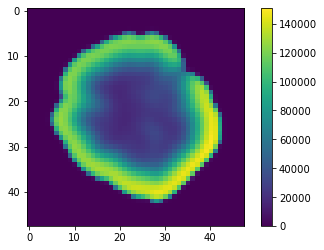

In [46]:
plt.imshow(ys_stack[-1,oms.rep_inds,...].sum(axis=0))#-ys_stack[-1,[cr_i,rb_i],...].prod(axis=0))
plt.colorbar()

In [21]:
# A = cnmg.cn_lhsA(h)
# x = im_arr[1,:,:,:].flatten()

sim_tmpl = './worker_outputs/chain_ncs{}_{}_it{:0d}.tif'
tvc_tmpl = './worker_outputs/chain_ncs{}_{}_it{:0d}_tvc.npy'
dt = 3
for ncs in np.arange(2,5):
    weights = [ncs, ncs, ncs, ncs, ncs, 100-4*ncs]
    for loop_i in np.arange(5):
        ns, nh, nw, _ = simmer.dims
        xs_vars = (('sa',250),('sr',0))
        new_init_conditions(simmer,weights)
        for csnr, xs in xs_vars:        
            ys = []
            ts = []
            p0=np.array([Dc,rc,rS,rR,Hn,Kn,Dn,kn,Da,xa,xs,xS,xr,hS,kS,hR,kR,hC,kC,pa,leak,min_od])
            simmer.set_p0(p0)
            impexp = cn_gmres.CNMGRK(simmer, 0, 2*60, first_step=dt, rk_step=dt/4)
            n_loops = np.int(14*3600/dt)
            rtime = time.time()
            for i in np.arange(n_loops):
                status, msg = impexp._step_impl()
                if status==False:
                    print(msg)
                    break
                if i%20:
                    continue
                else:
                    ys.append(impexp.y.copy())
                    ts.append(i*dt)
                if i%1000:
                    continue
                else:
                    print("completion:{:0.2f} dt:{}, loop:{}, cnsr:{}".format(i/n_loops,dt,loop_i,csnr))
                    print(dt*i/(time.time() - rtime))
            rtime = time.time() - rtime
            print("runtime:{:0.3f} minutes".format(rtime/60))
            species, nh, nw, dx = simmer.dims
            ys_reshaped = [xx.reshape((1,species,nh,nw)) for xx in ys]
            ys_stack = np.concatenate(ys_reshaped,axis=0)
            out_fn = sim_tmpl.format(ncs, csnr, loop_i)
            skimage.io.imsave(out_fn,ys_stack,plugin='tifffile')
            out_fn = tvc_tmpl.format(ncs, csnr, loop_i)
            np.save(out_fn, np.array(ts))
            print(out_fn)
    

completion:0.00 dt:3, loop:0, cnsr:sa
0.0
completion:0.06 dt:3, loop:0, cnsr:sa
102.12602997008854
completion:0.12 dt:3, loop:0, cnsr:sa
97.8132103723881
completion:0.18 dt:3, loop:0, cnsr:sa
93.2530148072589
completion:0.24 dt:3, loop:0, cnsr:sa
90.92450206076265
completion:0.30 dt:3, loop:0, cnsr:sa
89.68440468056566
completion:0.36 dt:3, loop:0, cnsr:sa
88.91811604181963
completion:0.42 dt:3, loop:0, cnsr:sa
88.38379815482648
completion:0.48 dt:3, loop:0, cnsr:sa
87.9449581415931
completion:0.54 dt:3, loop:0, cnsr:sa
86.90831177822474
completion:0.60 dt:3, loop:0, cnsr:sa
86.064920881127
completion:0.65 dt:3, loop:0, cnsr:sa
85.36440214308956
completion:0.71 dt:3, loop:0, cnsr:sa
84.8210082063641
completion:0.77 dt:3, loop:0, cnsr:sa
84.3042149853235
completion:0.83 dt:3, loop:0, cnsr:sa
83.88820624645423
completion:0.89 dt:3, loop:0, cnsr:sa
83.51394738094967
completion:0.95 dt:3, loop:0, cnsr:sa
83.21471759689346
runtime:10.122 minutes
./worker_outputs/chain_ncs2_sa_it0_tvc.npy
co

completion:0.24 dt:3, loop:4, cnsr:sa
87.30814470423213
completion:0.30 dt:3, loop:4, cnsr:sa
86.07790228456852
completion:0.36 dt:3, loop:4, cnsr:sa
85.09285370918515
completion:0.42 dt:3, loop:4, cnsr:sa
84.18672514733332
completion:0.48 dt:3, loop:4, cnsr:sa
83.51138549988684
completion:0.54 dt:3, loop:4, cnsr:sa
82.96320158589987
completion:0.60 dt:3, loop:4, cnsr:sa
82.5615504944794
completion:0.65 dt:3, loop:4, cnsr:sa
82.30009580289766
completion:0.71 dt:3, loop:4, cnsr:sa
82.07577137137284
completion:0.77 dt:3, loop:4, cnsr:sa
81.83828065698847
completion:0.83 dt:3, loop:4, cnsr:sa
81.68883200175645
completion:0.89 dt:3, loop:4, cnsr:sa
81.54811697868051
completion:0.95 dt:3, loop:4, cnsr:sa
81.38925275448918
runtime:10.331 minutes
./worker_outputs/chain_ncs2_sa_it4_tvc.npy
completion:0.00 dt:3, loop:4, cnsr:sr
0.0
completion:0.06 dt:3, loop:4, cnsr:sr
93.00274542210684
completion:0.12 dt:3, loop:4, cnsr:sr
89.3255634623079
completion:0.18 dt:3, loop:4, cnsr:sr
88.2729285309016

completion:0.48 dt:3, loop:3, cnsr:sa
87.25541188240744
completion:0.54 dt:3, loop:3, cnsr:sa
86.2142855412532
completion:0.60 dt:3, loop:3, cnsr:sa
85.40493989862415
completion:0.65 dt:3, loop:3, cnsr:sa
84.7779436070825
completion:0.71 dt:3, loop:3, cnsr:sa
84.2084553230783
completion:0.77 dt:3, loop:3, cnsr:sa
83.77087708696612
completion:0.83 dt:3, loop:3, cnsr:sa
83.4300834631513
completion:0.89 dt:3, loop:3, cnsr:sa
83.12241567389621
completion:0.95 dt:3, loop:3, cnsr:sa
82.87927673924776
runtime:10.157 minutes
./worker_outputs/chain_ncs3_sa_it3_tvc.npy
completion:0.00 dt:3, loop:3, cnsr:sr
0.0
completion:0.06 dt:3, loop:3, cnsr:sr
97.72644055376632
completion:0.12 dt:3, loop:3, cnsr:sr
92.0951928421356
completion:0.18 dt:3, loop:3, cnsr:sr
89.30532561457133
completion:0.24 dt:3, loop:3, cnsr:sr
88.44242734367846
completion:0.30 dt:3, loop:3, cnsr:sr
87.99861760289326
completion:0.36 dt:3, loop:3, cnsr:sr
87.74351020963688
completion:0.42 dt:3, loop:3, cnsr:sr
87.60054491955897
c

completion:0.71 dt:3, loop:2, cnsr:sa
85.41585857117529
completion:0.77 dt:3, loop:2, cnsr:sa
84.86741286240908
completion:0.83 dt:3, loop:2, cnsr:sa
84.4361535558627
completion:0.89 dt:3, loop:2, cnsr:sa
84.09768086595261
completion:0.95 dt:3, loop:2, cnsr:sa
83.74947723964726
runtime:10.054 minutes
./worker_outputs/chain_ncs4_sa_it2_tvc.npy
completion:0.00 dt:3, loop:2, cnsr:sr
0.0
completion:0.06 dt:3, loop:2, cnsr:sr
102.62199020557067
completion:0.12 dt:3, loop:2, cnsr:sr
100.15499298518135
completion:0.18 dt:3, loop:2, cnsr:sr
95.26706556781139
completion:0.24 dt:3, loop:2, cnsr:sr
93.02775104018319
completion:0.30 dt:3, loop:2, cnsr:sr
91.67320703438273
completion:0.36 dt:3, loop:2, cnsr:sr
90.876447718261
completion:0.42 dt:3, loop:2, cnsr:sr
90.32361950383786
completion:0.48 dt:3, loop:2, cnsr:sr
89.92274598215865
completion:0.54 dt:3, loop:2, cnsr:sr
89.49298508842371
completion:0.60 dt:3, loop:2, cnsr:sr
89.08659881743824
completion:0.65 dt:3, loop:2, cnsr:sr
88.695645681127

In [175]:

def write_chain_movie(im_arr, t_vec, skip=1, n_frames=200):
    cs_i, cra_i, crb_i, crc_i, crd_i, cp_i, n_i, aa_i, ab_i, ac_i, ad_i, sa_i, sb_i, sc_i, sd_i, ra_i, rb_i, rc_i, rd_i  = np.arange(oms.species)
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cs_i, cra_i, crb_i, crc_i, crd_i, cp_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot sender activity
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [cs_i, sa_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [sa_i, cp_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = 1e4#v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('Chain Index 0')
    im_list[ax_ind] = im
    
    # Plot receiver A activity
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [cra_i, sb_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = 1e4#v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('Chain Index 1')
    im_list[ax_ind] = im
    
    
    # Plot nutrient densities
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot receiver b activity
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [crb_i, sc_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = 1e4#v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('Chain Index 2')
    im_list[ax_ind] = im
    
    # Plot receiver b activity
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [crc_i, sd_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = 1e4#v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('Chain Index 3')
    im_list[ax_ind] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cs_i, cra_i, crb_i, crc_i, crd_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[3]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[1]
        indxs = [cs_i, sa_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
#         indxs = [s_i, cs_i]
#         frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[1].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[2]
        indxs = [cra_i, sb_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[2].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [crb_i, sc_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [crc_i, sd_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())



In [164]:

def write_movie(im_arr, t_vec, skip=1, n_frames=200):
    cs_i, cp_i, n_i, a_i, s_i, r_i = np.arange(6)
    frames, s, h, w = im_arr.shape
    t_points = np.arange(0,t_vec.max(),n_frames)
    f_points = np.arange(frames)
    
    #frames = len(t)
    
    t, s, h, w = im_arr.shape
    xticks = []
    xticklabels = []
    # First set up the figure, the axis, and the plot element we want to animate
    blank_array = np.zeros([h, w])
    fig, axs = plt.subplots(2,3, figsize=(10,7))
    axs = axs.flatten()
    im_list = [0,0,0,0,0,0]
    
    # Plot cell densities
    ax_ind = 0
    ax = axs[ax_ind]
    indxs = [cp_i, cs_i]
    vmax = im_arr[-1,indxs,:,:].sum(axis=0).max()
    vmin = im_arr[-1,indxs,:,:].sum(axis=0).min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks([])
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cell densities')
    im_list[ax_ind] = im
    
    # Plot nutrient densities
    ax_ind = 1
    ax = axs[ax_ind]
    indxs = [n_i]
    vmax = im_arr[:,indxs[0],:,:].max()
    vmin = im_arr[:,indxs[0],:,:].min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('nutrient')
    im_list[ax_ind] = im
    
    # Plot pulser synthase densities
    ax_ind = 2
    ax = axs[ax_ind]
    indxs = [s_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    indxs = [s_i, cs_i]
    v_arr += im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()/30
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('synthases')
    im_list[ax_ind] = im
    
    # Plot ahl conc
    ax_ind = 3
    ax = axs[ax_ind]
    indxs = [a_i]
    v_arr = im_arr[:,indxs,:,:]
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('ahl')
    im_list[ax_ind] = im
    
    # Plot pulser repressor densities
    ax_ind = 4
    ax = axs[ax_ind]
    indxs = [r_i, cp_i]
    v_arr = im_arr[:,indxs,:,:].prod(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('repr')
    im_list[ax_ind] = im
    
    # Plot total cellular protein
    ax_ind = 5
    ax = axs[ax_ind]
    indxs = [s_i, r_i]
    v_arr = im_arr[:,indxs,:,:].sum(axis=1)
    vmax = v_arr.max()
    vmin = v_arr.min()
    im = ax.imshow(blank_array, animated=True, vmax=vmax, vmin=vmin, interpolation='none', aspect=1)
    cbar = fig.colorbar(im, ax=ax, ticks=[vmin, vmax])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks([])
    ax.set_title('cellular protein')
    im_list[5] = im

    # animation function.  This is called sequentially
    t_points = np.linspace(0,t_vec.max(), 200)
    f_inds = []
    t_ind = 0
    for tp in t_points:
        while tp > t_vec[t_ind]:
            t_ind += 1
        f_inds.append(t_ind-1)
        
    def animate(t_point):
        i = f_inds[t_point]
        
        # Plot cell densities
        ax = axs[0]
        indxs = [cp_i, cs_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[0].set_array(frame_arr)

        # Plot nutrient densities
        ax = axs[1]
        indxs = [n_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[1].set_array(frame_arr)

        # Plot synthase densities
        ax = axs[2]
        indxs = [s_i, cp_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        indxs = [s_i, cs_i]
        frame_arr += im_arr[i,indxs,:,:].prod(axis=0)
        im_list[2].set_array(frame_arr)
        
        # Plot ahl
        ax = axs[3]
        indxs = [a_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[3].set_array(frame_arr)

        # Plot repr
        ax = axs[4]
        indxs = [cp_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].prod(axis=0)
        im_list[4].set_array(frame_arr)

        # Plot cellular protein
        ax = axs[5]
        indxs = [s_i, r_i]
        frame_arr = im_arr[i,indxs,:,:].sum(axis=0)
        im_list[5].set_array(frame_arr)

        #return im_list,

    # call the animator.  blit=True means only re-draw the parts that have changed.
    anim = anm.FuncAnimation(fig, animate, interval=50, frames=n_frames)

#     anim.save('./animation_test.gif', writer='pillow')
#     fig.tight_layout()
    plt.close('all')
    return anim
#     HTML(anim.to_html5_video())


def prep_initial_condition(cs_spots, cp_spots, ahl_spots, dims, p0, A):
    rp,    Kn,  Dn, Da, xs, xS, xr, hS, hR, kR, hC, pa, leak, od = p0
    species, n_h, n_w = dims
    
    cs_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cs_spots:
        cs_cells += disk(cs_cells, np.array(center), scale_s)*od
        
    cp_cells = np.zeros((n_h, n_w), dtype=np.float32)
    for center in cp_spots:
        cp_cells += disk(cp_cells, np.array(center), scale_s)*od
        
    ahl_drops = np.zeros((n_h, n_w), dtype=np.float32)
    for center in ahl_spots:
        ahl_drops += disk(ahl_drops, np.array(center), scale_s)*2.5e3
    
    # Set initial conditions
    for ind, cell_arr in zip([cs_i, cp_i], [cs_cells, cp_cells]):
        A[ind,:,:] += cell_arr
#         A[ind,:,:] += ndi.filters.gaussian_filter(cell_arr, scale_s)
    
    # External cin AHL.
    A[a_i,:,:] += ndi.filters.gaussian_filter(ahl_drops, scale_s)
    
    return A



In [167]:
import skimage.io
img1 = skimage.io.imread('worker_outputs/chain_ncs4_sa_it3.tif')
img2 = skimage.io.imread('worker_outputs/chain_ncs4_sr_it3.tif')

In [176]:
anim = write_chain_movie(img1,np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [177]:
anim = write_chain_movie(img2,np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

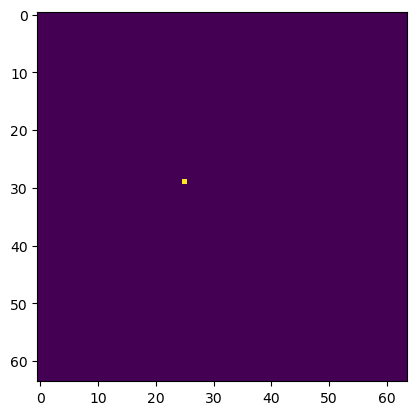

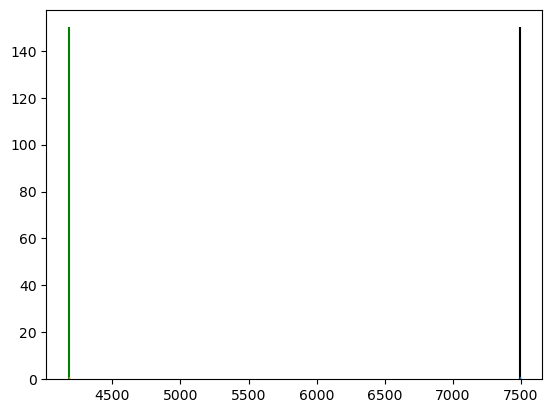

In [76]:
max_img = (img1[:,[cra_i,sb_i],...].prod(axis=1)*(img1[:,cra_i,...]>1)).max(axis=0)
plt.imshow(max_img)
plt.figure()
_ = plt.hist(max_img[max_img>1e1].flatten(),bins=40,histtype='step')
plt.vlines(np.median(max_img[max_img>1e3]),0,150,'k')
max_img = (img2[:,[cra_i,sb_i],...].prod(axis=1)*(img1[:,cra_i,...]>1)).max(axis=0)
_ = plt.hist(max_img[max_img>1e1].flatten(),bins=40,histtype='step')
plt.vlines(np.median(max_img[max_img>1e3]),0,150,'g')

In [121]:
plt.rcParams['animation.ffmpeg_path'] = '/home/jparkin/anaconda3/bin/ffmpeg' # Add the path of ffmpeg here!!
anm.writers.avail

/home/jparkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The avail attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  


{'pillow': matplotlib.animation.PillowWriter,
 'ffmpeg': matplotlib.animation.FFMpegWriter,
 'ffmpeg_file': matplotlib.animation.FFMpegFileWriter,
 'imagemagick': matplotlib.animation.ImageMagickWriter,
 'imagemagick_file': matplotlib.animation.ImageMagickFileWriter,
 'html': matplotlib.animation.HTMLWriter}

In [ ]:
cs_i, cra_i, crb_i, crc_i, crd_i, cp_i, n_i, aa_i, ab_i, ac_i, ad_i, sa_i, sb_i, sc_i, sd_i, ra_i, rb_i, rc_i, rd_i  = np.arange(oms.species)
anim = write_movie(img1[:,[cs_i,cp_i,n_i,aa_i,sa_i,ra_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img1[:,[cra_i,cp_i,n_i,ab_i,sb_i,rb_i],...],np.arange(img2.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img1[:,[crb_i,cp_i,n_i,ac_i,sc_i,rc_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img1[:,[crc_i,cp_i,n_i,ad_i,sd_i,rd_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
cs_i, cra_i, crb_i, crc_i, crd_i, cp_i, n_i, aa_i, ab_i, ac_i, ad_i, sa_i, sb_i, sc_i, sd_i, ra_i, rb_i, rc_i, rd_i  = np.arange(oms.species)
anim = write_movie(img2[:,[cs_i,cp_i,n_i,aa_i,sa_i,ra_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img2[:,[cra_i,cp_i,n_i,ab_i,sb_i,rb_i],...],np.arange(img2.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img2[:,[crb_i,cp_i,n_i,ac_i,sc_i,rc_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img2[:,[crc_i,cp_i,n_i,ad_i,sd_i,rd_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(img2,np.arange(img2.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
grid_volume = (1/scale)**3 # mm^3
layer_amount = img2[-1,a_i,...].sum()*grid_volume # nM * mm^3
full_pad_amount = layer_amount*(2*scale) # upper bound, assumes no gradient
full_pad_conc = full_pad_amount / (2*scale*(64/scale)**2)
print(full_pad_conc)
# 32*((img1[-1,a_i,...].sum()-0*img2[-1,a_i,...].sum())*1e-3*(1e-1/16)**3)/1e-3

In [ ]:
plt.imshow(img1[-5,[s_i,cp_i],:,:].prod(axis=0))

In [6]:
import skimage.io

# ncs_vec = np.arange(2,5)
# loop_vec = np.arange(5)
# nci, li = ncs_vec[2], loop_vec[0]
# sim_tmpl = './worker_outputs/chain_ncs{}_{}_it{:0d}.tif'
# tvc_tmpl = './worker_outputs/chain_ncs{}_{}_it{:0d}_tvc.npy'
# img1 = skimage.io.imread(sim_tmpl.format(nci,'sa',li))
# img2 = skimage.io.imread(sim_tmpl.format(nci,'sr',li))

def load_imgs(nc, li, csnr):
    if nc==1:
        sim_tmpl = './worker_outputs/chain_{}_it{:0d}.tif'
        sim_fn = sim_tmpl.format(csnr,li)
    else:
        sim_tmpl = './worker_outputs/chain_ncs{}_{}_it{:0d}.tif'
        sim_fn = sim_tmpl.format(nc,csnr,li)
    img = skimage.io.imread(sim_fn)
    return img

In [55]:
del df_list

In [85]:
df_list = []
for ncs in np.arange(1,5):
    for li in np.arange(5):
        for cnsr in ['sa','sr']:
            for _, s_i, _, c_i in oms.ahl_prod_tuples:
                img = load_imgs(ncs, li,cnsr)
                rep_vec = img[:,[c_i,s_i],...].prod(axis=1).max(axis=0)
                bool_vec = img[-1,c_i,...] > 0.5
                rep_vec = rep_vec[bool_vec].flatten()
                df = pd.DataFrame({'fluor':rep_vec})
                df['cnsr'] = cnsr
                df['iter'] = li
                df['ncs'] = ncs
                df['ci'] = c_i
                df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

In [78]:
all_df.head()

,fluor,cnsr,iter,ncs,ci
0,59751.786703,sa,0,2,1
1,69307.248972,sa,0,2,1
2,75578.685380,sa,0,2,1
3,52454.318471,sa,0,2,1
4,60893.951318,sa,0,2,1


In [66]:
df_list = []
for ncs in np.arange(1,5):
    for li in np.arange(5):
        img1 = load_imgs(ncs, li,'sa')
        img2 = load_imgs(ncs, li,'sr')
        for r_i in [ra_i, rb_i, rc_i, rd_i]:
            rep_vec1 = img1[:,[cp_i,r_i],...].prod(axis=1).max(axis=0)
            bool_vec = img1[-1,cp_i,...] > 1
            rep_vec2 = img2[:,[cp_i,r_i],...].prod(axis=1).max(axis=0)
            bool_vec = (img2[-1,cp_i,...] > 1)&bool_vec
            rep_vec = (rep_vec1-rep_vec2)[bool_vec].flatten()
            df = pd.DataFrame({'fluor':rep_vec})
            df['iter'] = li
            df['ncs'] = ncs
            df['ri'] = r_i
            df_list.append(df)
all_df = pd.concat(df_list, ignore_index=True)

In [72]:
sub_df = all_df.loc[(all_df.fluor.values>0),:].copy()

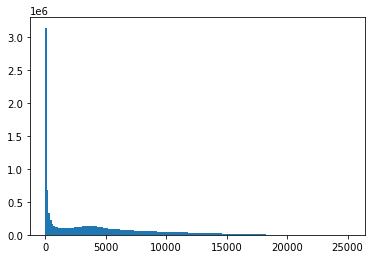

In [9]:
_ = plt.hist(sub_df.fluor,bins=200)

[Text(0, 0.5, ''),
 Text(0, 0.0, '1'),
 Text(0, -0.5, ''),
 Text(0, -1.0, '1/10'),
 Text(0, -1.5, ''),
 Text(0, -2.0, '1/100'),
 Text(0, -2.5, ''),
 Text(0, -3.0, '1/1000')]

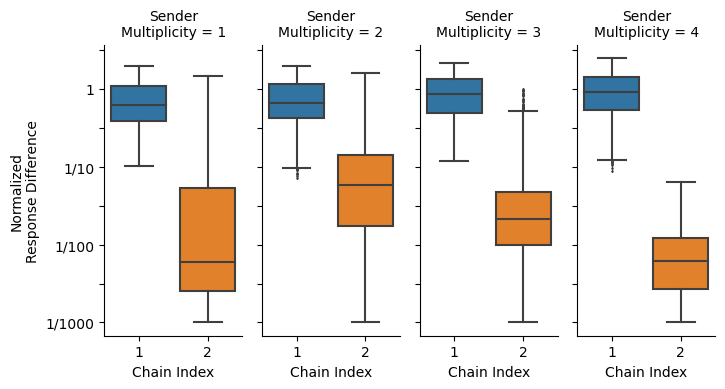

In [69]:
import seaborn as sns
plt.style.use('default')
plt.style.use('fast')
sub_df['logfluor'] = np.log10(sub_df.fluor.values)
ri_dict = dict(zip([ra_i,rb_i,rc_i,rd_i],['1','2','3','4']))
conv_ri = lambda x : ri_dict[x]
sub_df['Chain Index'] = sub_df.ri.apply(conv_ri)
sub_df['Sender\nMultiplicity'] = sub_df.ncs
sub_df['Normalized\nResponse Difference'] = sub_df.logfluor-4
g = sns.catplot(x="Chain Index", y='Normalized\nResponse Difference',col="Sender\nMultiplicity",
                data=sub_df, kind="box",fliersize=1,
                height=4, aspect=.45);
yticks = np.arange(0.5,-3.5,-0.5)
labels = []
for ytick in yticks:
    if (ytick%1)<0.2:
        if ytick==0:
            labels.append("1")
        else:
            labels.append("1/{:d}".format(np.int(10**np.abs(ytick))))
    else:
        labels.append('')
g.axes[0][0].set_yticks(yticks)
g.axes[0][0].set_yticklabels(labels)

In [24]:
g.axes[0][0]

<AxesSubplot:title={'center':'Sender\nMultiplicity = 1'}, xlabel='Chain Index', ylabel='Normalized\nResponse Difference'>

In [25]:
g.savefig('figs/chain_comp.png',transparent=True,dpi=110)
g.savefig('figs/chain_comp.pdf',transparent=True,dpi=110)

In [27]:
import seaborn as sns

In [104]:
sub_df = all_df.loc[(all_df.fluor.values>500),:].groupby(['cnsr','iter','ncs','ci']).agg(np.mean).reset_index()

[Text(0, 3.0, '10^3'),
 Text(0, 3.5, ''),
 Text(0, 4.0, '10^4'),
 Text(0, 4.5, ''),
 Text(0, 5.0, '10^5'),
 Text(0, 5.5, '')]

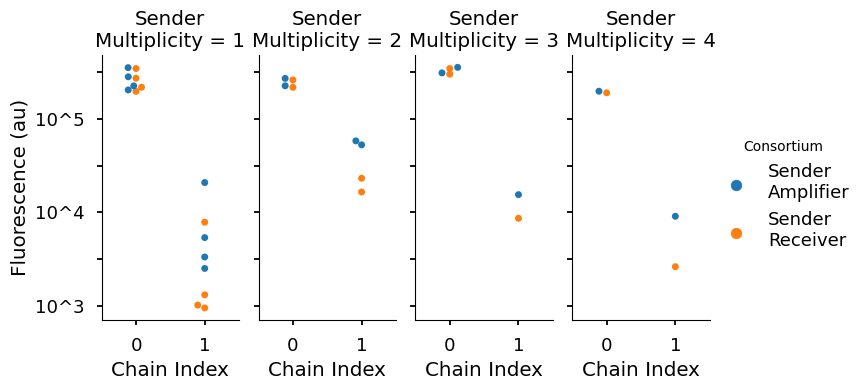

In [109]:
import seaborn as sns
plt.style.use('default')
plt.style.use('seaborn-talk')
sub_df['logfluor'] = np.log10(sub_df.fluor.values)
ri_dict = dict(zip([cs_i,cra_i,crb_i,crc_i,crd_i],['0','1','2','3','4']))
conv_ri = lambda x : ri_dict[x]
sub_df['Chain Index'] = sub_df.ci.apply(conv_ri)
sub_df['Sender\nMultiplicity'] = sub_df.ncs
sub_df['Fluorescence (au)'] = sub_df.logfluor
ri_dict = dict(zip(['sa','sr'],['Sender\nAmplifier','Sender\nReceiver']))
conv_ri = lambda x : ri_dict[x]
sub_df['Consortium'] = sub_df.cnsr.apply(conv_ri)
g = sns.catplot(x="Chain Index", y='Fluorescence (au)',col="Sender\nMultiplicity",
                data=sub_df, kind="swarm",hue='Consortium',
                height=4, aspect=.45);
yticks = np.arange(3,6,0.5)
labels = []
for ytick in yticks:
    if (ytick%1)<0.2:
        if ytick==0:
            labels.append("1")
        else:
            labels.append(r"10^{:d}".format(np.int(ytick)))
    else:
        labels.append('')
g.axes[0][0].set_yticks(yticks)
g.axes[0][0].set_yticklabels(labels)

In [106]:
g.savefig('figs/chain_fluor_swarm.png',transparent=True,dpi=110)
g.savefig('figs/chain_fluor_swarm.pdf',transparent=True,dpi=110)

In [48]:
sub_df.columns

Index(['fluor', 'cnsr', 'iter', 'ncs', 'ci', 'logfluor', 'Chain Index',
       'Sender\nMultiplicity', 'Fluorescence', 'Consortium'],
      dtype='object')

[Text(0, 0.0, '1'),
 Text(0, 0.5, ''),
 Text(0, 1.0, '10^1'),
 Text(0, 1.5, ''),
 Text(0, 2.0, '10^2'),
 Text(0, 2.5, ''),
 Text(0, 3.0, '10^3'),
 Text(0, 3.5, ''),
 Text(0, 4.0, '10^4'),
 Text(0, 4.5, ''),
 Text(0, 5.0, '10^5'),
 Text(0, 5.5, '')]

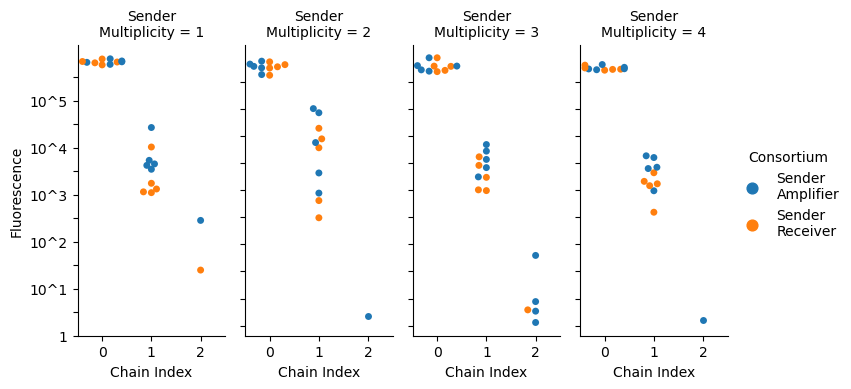

In [60]:
import seaborn as sns
plt.style.use('default')
plt.style.use('fast')
sub_df = sub_df = all_df.loc[(all_df.fluor.values>10),:].copy()
sub_df = sub_df.groupby(['cnsr','ci','iter','ncs']).agg(lambda x : np.max(x)).reset_index()
sub_df['logfluor'] = np.log10(sub_df.fluor.values)
ri_dict = dict(zip([cs_i,cra_i,crb_i,crc_i,crd_i],['0','1','2','3','4']))
conv_ri = lambda x : ri_dict[x]
sub_df['Chain Index'] = sub_df.ci.apply(conv_ri)
sub_df['Sender\nMultiplicity'] = sub_df.ncs
sub_df['Fluorescence'] = sub_df.logfluor
ri_dict = dict(zip(['sa','sr'],['Sender\nAmplifier','Sender\nReceiver']))
conv_ri = lambda x : ri_dict[x]
sub_df['Consortium'] = sub_df.cnsr.apply(conv_ri)
g = sns.catplot(x="Chain Index", y='Fluorescence',col="Sender\nMultiplicity",
                data=sub_df, kind="swarm",hue='Consortium',
                height=4, aspect=.45);
yticks = np.arange(0,6,0.5)
labels = []
for ytick in yticks:
    if (ytick%1)<0.2:
        if ytick==0:
            labels.append("1")
        else:
            labels.append(r"10^{:d}".format(np.int(ytick)))
    else:
        labels.append('')
g.axes[0][0].set_yticks(yticks)
g.axes[0][0].set_yticklabels(labels)

In [47]:
g.savefig('figs/chain_fluor.png',transparent=True,dpi=110)
g.savefig('figs/chain_fluor.pdf',transparent=True,dpi=110)

In [16]:
all_df.groupby(['cnsr','iter','ncs','ri']).apply(len)

cnsr  iter  ncs  ri
sa    0     1    15    427160
                 16    427160
                 17    427160
                 18    427160
            2    15    412180
                        ...  
sr    4     3    18    424474
            4    15    433562
                 16    433562
                 17    433562
                 18    433562
Length: 160, dtype: int64

In [15]:
plt.close('all')

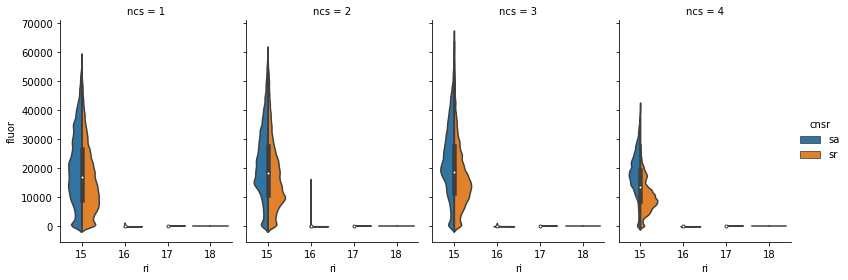

In [10]:
sub_all_df = all_df.loc[all_df.fluor>1e3,:]
g = sns.catplot(x="ri", y="fluor",
                hue="cnsr", col="ncs",
                data=all_df.groupby('iter').get_group(0), kind="violin", split=True,
                height=4, aspect=.7);

In [61]:
ax = sns.violinplot(x="ri", y="fluor", hue="cnsr",
                    data=all_df, palette="muted", split=True)

KeyboardInterrupt: 

In [ ]:
cs_i, cra_i, crb_i, crc_i, crd_i, cp_i, n_i, aa_i, ab_i, ac_i, ad_i, sa_i, sb_i, sc_i, sd_i, ra_i, rb_i, rc_i, rd_i  = np.arange(oms.species)
anim = write_movie(diff_img[:,[cs_i,cp_i,n_i,aa_i,sa_i,ra_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(diff_img[:,[cra_i,cp_i,n_i,ab_i,sb_i,rb_i],...],np.arange(img2.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(diff_img[:,[crb_i,cp_i,n_i,ac_i,sc_i,rc_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
anim = write_movie(diff_img[:,[crc_i,cp_i,n_i,ad_i,sd_i,rd_i],...],np.arange(img1.shape[0]))
HTML(anim.to_html5_video())

In [ ]:
plt.i